In [1]:
import PIL
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F


import torchvision
from torchvision.ops import nms
from torchvision.ops import RoIPool

from torchvision.ops import boxes as box_ops

import pandas as pd
import os
from tqdm.notebook import trange, tqdm
import cv2

import xml.etree.ElementTree as ET

In [2]:
use_cuda = True
device = torch.device('cuda:4' if use_cuda else 'cpu')
x = torch.Tensor([0]).cuda(device)

In [3]:
def drawbbox(img, pre, keep = None, color = '#FF4565'):
    img1 = img.copy()
    ImageD = ImageDraw.Draw(img1)
    for i in range(len(pre['boxes'])):
        if keep is not None and i not in keep:
            continue
        box = pre['boxes'][i]
        ImageD.rectangle([(box[0],box[1]),box[2],box[3]],outline= color,width = 2)
        cls_dict = { 'A220':0,
             'A330':1, 
             'A320/321':2, 
             'Boeing737-800':3,
             'Boeing787':4,
             'ARJ21':5, 
             'other':6}
        
        index_dict = {j:i for i,j in cls_dict.items()}
        text = ''
        try:
            label = pre['labels'][i]
            text = text + index_dict[int(label)]
        except:
            pass
        try:
            score = pre['scores'][i]
            text = text + ':' + str(float(score))[:5]
        except:
            pass
        c = (int(box[0]),int(box[1])-12)
        font = ImageFont.truetype('consolab.ttf',size = 11)
        b = ImageD.textbbox(c,text,font)

        ImageD.rectangle([(b[0],b[1]),b[2]+2,b[3]],fill = color,outline= color)
        ImageD.text(c,text,fill = (255,255,255),font = font,stroke_width=0)
    return img1

# 数据集读取

In [4]:
path = 'data/SAR_Airplane_Recognition_trainData/trainData/'
image_path = path + 'Images/'
gt_path = path + 'gt/'

In [5]:
def parsexml(gt_path, filename):
    gt_filename = gt_path + filename
    gt_sample = ET.parse(gt_filename)

    img_filename = gt_sample.find('source').find('filename').text

    Objects = gt_sample.find('objects').findall('object')
    objects_name = []
    bboxes = []
    for object in Objects:
        object_name = object.find('possibleresult').find('name').text
        objects_name.append(object_name)
        points = object.find('points').findall('point')
        xmin,ymin = points[0].text.split(',')
        xmax,ymax = points[2].text.split(',')
        bbox = [int(float(xmin)), int(float(ymin)), int(float(xmax)), int(float(ymax))]
        bboxes.append(torch.Tensor(bbox))
    cls_dict = { 'A220':0,
                 'A330':1, 
                 'A320/321':2, 
                 'Boeing737-800':3,
                 'Boeing787':4,
                 'ARJ21':5, 
                 'other':6}
    target = {
                'filename':img_filename,
                'labels':[cls_dict[i] for i in objects_name],
                'boxes':bboxes
            }
    return target

In [6]:
parsexml(gt_path,'2.xml')

{'filename': '2.tif',
 'labels': [6, 0, 6, 5, 6],
 'boxes': [tensor([147., 105., 239., 173.]),
  tensor([145.,   1., 252.,  73.]),
  tensor([157., 228., 239., 293.]),
  tensor([242., 879., 307., 936.]),
  tensor([312., 882., 383., 934.])]}

In [7]:
gt_dir = sorted([i for i in os.listdir(gt_path) if i[-3:] == 'xml'])
targets = []
for filename in gt_dir:
    targets.append(parsexml(gt_path,filename))

In [8]:
targets[456]

{'filename': '1409.tif',
 'labels': [4, 4],
 'boxes': [tensor([  1., 398., 119., 532.]), tensor([ 10., 232., 114., 331.])]}

In [9]:
# imgs = []
# for target in tqdm(targets, desc = 'Load data'):
#     filename = target['filename']
#     img = cv2.imread(image_path + filename)
#     img = torch.from_numpy(img)
#     imgs.append(img)

In [10]:
class SAR_dset(torch.utils.data.Dataset):
    def __init__(self, path = 'data/SAR_Airplane_Recognition_trainData/trainData/'):
        super(SAR_dset, self).__init__()
        self.image_path = path + 'Images/'
        self.gt_path = path + 'gt/'
        self.gt_dir = sorted([i for i in os.listdir(self.gt_path) if i[-3:] == 'xml'])
        self.targets = []
        for filename in  self.gt_dir:
            self.targets.append(self.parsexml(gt_path,filename))
        
        self.imgs = []
        for target in tqdm(self.targets, desc = 'Load data'):
            filename = target['filename']
            img = cv2.imread(self.image_path + filename)
            img = torch.from_numpy(img).permute(2,0,1)/255
            self.imgs.append(img)
        
        self.train_img = self.imgs[:1000]
        self.train_targets = self.targets[:1000]
        
        self.test_img = self.imgs[1000:]
        self.test_targets = self.targets[1000:]
        self.mode = 'train'
        
        
        
    def __getitem__(self, index):
        if self.mode == 'train':
            return self.train_img[index],self.train_targets[index]
        else:
            return self.test_img[index],self.test_targets[index]
    
    def __len__(self):
        if self.mode == 'train':
            return len(self.train_img)
        else:
            len(self.test_img)
    

        
    def parsexml(self, gt_path, filename):
        gt_filename = gt_path + filename
        gt_sample = ET.parse(gt_filename)

        img_filename = gt_sample.find('source').find('filename').text

        Objects = gt_sample.find('objects').findall('object')
        objects_name = []
        bboxes = []
        for object in Objects:
            object_name = object.find('possibleresult').find('name').text
            objects_name.append(object_name)
            points = object.find('points').findall('point')
            xmin,ymin = points[0].text.split(',')
            xmax,ymax = points[2].text.split(',')
            bbox = [int(float(xmin)), int(float(ymin)), int(float(xmax)), int(float(ymax))]
            bboxes.append(torch.Tensor(bbox))
        cls_dict = { 'A220':0,
                     'A330':1, 
                     'A320/321':2, 
                     'Boeing737-800':3,
                     'Boeing787':4,
                     'ARJ21':5, 
                     'other':6}
        target = {
                    'filename':img_filename,
                    'labels':[cls_dict[i] for i in objects_name],
                    'boxes':bboxes
                }
        return target

In [11]:
sar_dset = SAR_dset()

Load data:   0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
sar_dset.test_targets[0]

{'filename': '19.tif',
 'labels': [4, 4, 4],
 'boxes': [tensor([208., 544., 292., 599.]),
  tensor([326., 538., 391., 599.]),
  tensor([ 89., 557., 161., 599.])]}

In [13]:
def collect(batch):
#     print(batch)
    img,target = [item for item in zip(*batch)]
    for i in range(len(target)):
        if isinstance(target[i]['boxes'],list):
            target[i]['boxes'] = torch.stack(target[i]['boxes'],dim = 0)
            target[i]['labels'] = torch.from_numpy(np.array(target[i]['labels'],dtype = np.int64))
    return img,target

In [14]:
sar_dataloader = torch.utils.data.DataLoader(sar_dset, batch_size = 16, shuffle = True,collate_fn = collect)

In [15]:
for x,y in tqdm(sar_dataloader):
    pass

  0%|          | 0/125 [00:00<?, ?it/s]

In [16]:
resnet_model = torchvision.models.resnet50(pretrained = True)
'''
    特征提取网络，不使用FPN
'''
features_list = [
                    resnet_model.conv1,
                    resnet_model.bn1,
                    resnet_model.relu,
                    resnet_model.maxpool,
                    resnet_model.layer1,
                    resnet_model.layer2,
                    resnet_model.layer3,
                ]
backbone = nn.Sequential(*features_list)
backbone.out_channels = 1024

In [17]:
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=14,
                                                sampling_ratio=2)
anchor_generator = torchvision.models.detection.rpn.AnchorGenerator( sizes=((16, 32, 64, 128, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))
faster_rcnn = torchvision.models.detection.FasterRCNN(backbone,
                                        num_classes = 7,
                                        min_size = 200,
                                        max_size = 5000,
                                        rpn_anchor_generator=anchor_generator,
                                        box_roi_pool=roi_pooler)
faster_rcnn.to(device)
x = [i.cuda(device) for i in x]
for i in range(len(y)):
    y[i]['labels'] = y[i]['labels'].cuda(device)
    y[i]['boxes'] = y[i]['boxes'].cuda(device)
y

({'filename': '1550.tif',
  'labels': tensor([6, 0], device='cuda:4'),
  'boxes': tensor([[547., 505., 599., 573.],
          [545., 386., 599., 473.]], device='cuda:4')},
 {'filename': '1422.tif',
  'labels': tensor([6, 6], device='cuda:4'),
  'boxes': tensor([[ 32.,  23.,  60.,  54.],
          [ 82., 129., 113., 164.]], device='cuda:4')},
 {'filename': '1118.tif',
  'labels': tensor([6, 5, 6], device='cuda:4'),
  'boxes': tensor([[1243.,  641., 1375.,  766.],
          [1212.,  811., 1373.,  920.],
          [1234.,  981., 1320., 1050.]], device='cuda:4')},
 {'filename': '1804.tif',
  'labels': tensor([5, 5], device='cuda:4'),
  'boxes': tensor([[ 17.,  78.,  65., 132.],
          [  1., 293.,  61., 356.]], device='cuda:4')},
 {'filename': '1460.tif',
  'labels': tensor([6, 6, 6, 6, 6, 6], device='cuda:4'),
  'boxes': tensor([[383., 314., 440., 355.],
          [326., 309., 365., 344.],
          [235., 476., 282., 532.],
          [171., 470., 215., 522.],
          [105., 461., 14

In [18]:
faster_rcnn(x, y)

{'loss_classifier': tensor(1.9350, device='cuda:4', grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.0126, device='cuda:4', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.6942, device='cuda:4', grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0079, device='cuda:4', grad_fn=<DivBackward0>)}

In [21]:
faster_rcnn = torch.load('model/competition1.pt')
optimizer = optim.AdamW(faster_rcnn.parameters(), 0.001)

In [22]:
faster_rcnn.train()
Epoch = 10
min_loss = 123000000
for epoch in trange(Epoch,desc = 'Epoch'):
    myiter = tqdm(sar_dataloader,colour = '#0066FF')
    myiter.set_description_str('Training')
    loss1 = 0
    for x,y in myiter:
        x = [i.cuda(device) for i in x]
        for i in range(len(y)):
            y[i]['labels'] = y[i]['labels'].cuda(device)
            y[i]['boxes'] = y[i]['boxes'].cuda(device)
        
        loss_dict = faster_rcnn(x,y)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        myiter.set_postfix(loss = float(loss),epoch = epoch, loss_all = loss1)
        loss1 += float(loss)
    if loss1 < min_loss:
        min_loss = loss1
        torch.save(faster_rcnn,'model/competition1.pt')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [43]:
faster_rcnn.eval()
index = 782
x = [sar_dset.test_img[index].cuda(device)]
labels = sar_dset.test_targets[index]
targets = faster_rcnn(x)[0]

In [44]:
img = x[0].permute(1,2,0).cpu().numpy()
img.shape

(600, 600, 3)

In [45]:
img1 = Image.fromarray(np.array(img*255,dtype = np.uint8))

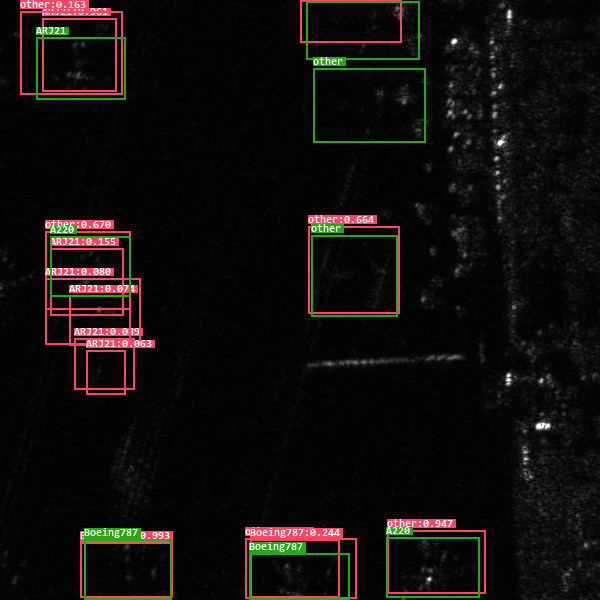

In [46]:
img_nonms = drawbbox(img1,targets)
drawbbox(img_nonms,labels,color = '#24AA12')

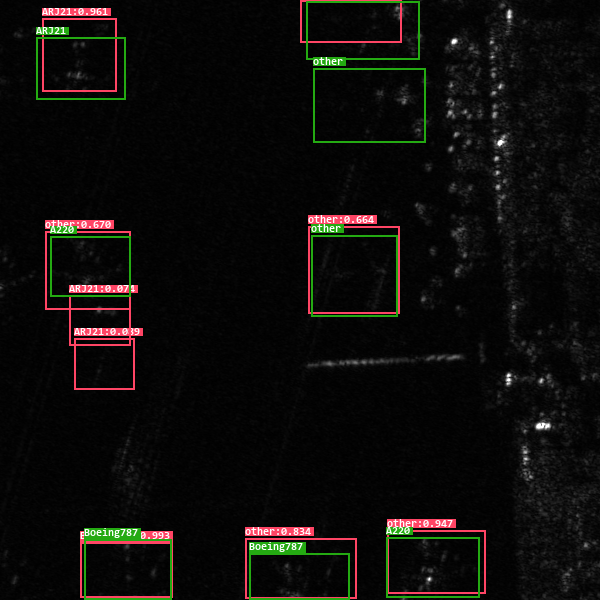

In [47]:
keep = nms(targets['boxes'], targets['scores'],0.2)
img_nms = drawbbox(img1,targets,keep)
drawbbox(img_nms,labels,color = '#24AA12')